<a href="https://colab.research.google.com/github/Paymanshus/DL_Sem_VI/blob/main/Exp1/DL_Exp1_Arabic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Arabic Character Recognition

In [1]:
from google.colab import drive
# drive.mount('content/drive')

In [2]:
!wget http://upscfever.com/datasets/csvTrainImages13440x1024.csv -P drive/app
!wget http://upscfever.com/datasets/csvTrainLabel13440x1.csv -P drive/app
!wget http://upscfever.com/datasets/csvTestImages3360x1024.csv -P drive/app
!wget http://upscfever.com/datasets/csvTestLabel3360x1.csv -P drive/app

--2020-12-07 01:36:53--  http://upscfever.com/datasets/csvTrainImages13440x1024.csv
Resolving upscfever.com (upscfever.com)... 104.27.176.133, 104.27.177.133, 172.67.193.2, ...
Connecting to upscfever.com (upscfever.com)|104.27.176.133|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://upscfever.com/datasets/csvTrainImages13440x1024.csv [following]
--2020-12-07 01:36:53--  https://upscfever.com/datasets/csvTrainImages13440x1024.csv
Connecting to upscfever.com (upscfever.com)|104.27.176.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘drive/app/csvTrainImages13440x1024.csv’

csvTrainImages13440     [ <=>                ]  28.22M  --.-KB/s    in 0.1s    

2020-12-07 01:36:54 (213 MB/s) - ‘drive/app/csvTrainImages13440x1024.csv’ saved [29593405]

--2020-12-07 01:36:54--  http://upscfever.com/datasets/csvTrainLabel13440x1.csv
Resolving upscfever.com (upscfever.com)... 104.27.176.1

## Importing required libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras

from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras import layers
from keras import models
from keras import optimizers

from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dropout, Flatten, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential

import cv2
from tqdm import tqdm
import os
import random as rn

In [4]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

## Data Preparation

In [5]:
train_data = pd.read_csv('drive/app/csvTrainImages13440x1024.csv', header=None)
train_label = pd.read_csv('drive/app/csvTrainLabel13440x1.csv', header = None)
test_data = pd.read_csv('drive/app/csvTestImages3360x1024.csv', header = None)
test_label = pd.read_csv('drive/app/csvTestLabel3360x1.csv', header = None)

In [6]:
train_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13435,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13436,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13437,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13438,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13440 entries, 0 to 13439
Columns: 1024 entries, 0 to 1023
dtypes: int64(1024)
memory usage: 105.0 MB


In [8]:
train_data = train_data.iloc[:,:].values.astype('float32')
train_label = train_label.iloc[:,:].values.astype('int32')-1
test_data = test_data.iloc[:,:].values.astype('float32')
test_label = test_label.iloc[:,:].values.astype('int32')-1

In [9]:
train_data.dtype

dtype('float32')

In [10]:
train_data.shape

(13440, 1024)

In [11]:
def row_calculator(number_of_images, number_of_columns):
    if number_of_images % number_of_columns != 0:
        return (number_of_images / number_of_columns)+1
    else:
        return (number_of_images / number_of_columns)

In [12]:
def display_image(x, img_size, number_of_images):
    plt.figure(figsize = (8, 7))
    if x.shape[0] > 0:
        n_samples = x.shape[0]
        x = x.reshape(n_samples, img_size, img_size) # Converting training data df shape from individual pixels format to 32x32
        number_of_rows = row_calculator(number_of_images, number_of_columns=4)
        for i in range(number_of_images):
            plt.subplot(number_of_rows, 4, i+1)
            plt.imshow(x[i], cmap='bone')

In [13]:
IMG_SIZE = 32

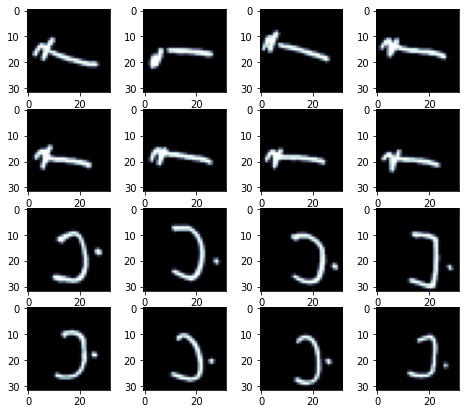

In [14]:
display_image(train_data, IMG_SIZE, 16)

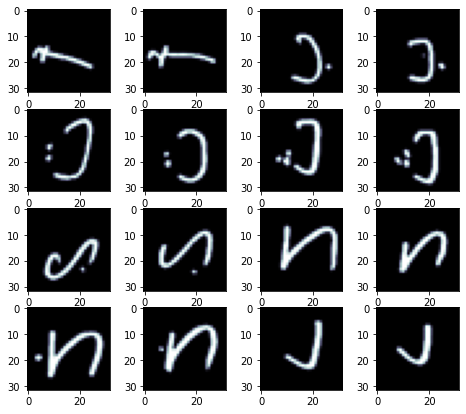

In [15]:
display_image(test_data, IMG_SIZE, 16)

In [16]:
train_label = to_categorical(train_label,28)
test_label = to_categorical(test_label, 28)

In [17]:
train_label

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [18]:
# Normalization
train_data = train_data/255 
test_data = test_data/255

In [19]:
# Reshaping to make data look like 2D image
train_data = train_data.reshape([-1, 32, 32, 1])
test_data = test_data.reshape([-1, 32, 32, 1])

In [20]:
IMG_SIZE=32
BATCH_SIZE=120
TRAIN_SIZE = train_data.shape[0]*0.8
VAL_SIZE = train_data.shape[0]*0.2

In [21]:
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,  
        width_shift_range=0.1, 
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False,
        validation_split=0.2
        )

test_datagen = ImageDataGenerator()

In [22]:
# datagen.fit(train_data)

In [23]:
train_generator = datagen.flow(
    train_data, train_label,
    batch_size=BATCH_SIZE,
    # class_mode='categorical',
    subset='training',
    # target_size=(IMG_SIZE,IMG_SIZE),
    shuffle=True,
    seed=42
)

validation_generator = datagen.flow(
    train_data, train_label,
    batch_size=BATCH_SIZE,
    shuffle=True,
    # target_size=(IMG_SIZE, IMG_SIZE),
    # class_mode='categorical',
    subset='validation',
    seed=42
)

test_generator = datagen.flow(
    test_data, 
    batch_size = BATCH_SIZE,
    # target_size=(IMG_SIZE, IMG_SIZE),
    # class_mode='categorical'
)

### Modelling

In [24]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import RMSprop

In [31]:
# Callbacks

es = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=10)
mc = ModelCheckpoint('best_weights.hdf5', monitor='val_accuracy', save_best_only=True, mode='max')
rd = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, mode='auto')

In [51]:
arab_model = Sequential()

arab_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (32,32,1)))
arab_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
arab_model.add(MaxPooling2D(pool_size=(2,2)))
# arab_model.add(Dropout(0.25))
# arab_model.add(keras.layers.BatchNormalization())


arab_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
arab_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
arab_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
# arab_model.add(Dropout(0.25))
arab_model.add(keras.layers.BatchNormalization())


arab_model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
arab_model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
arab_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
# arab_model.add(Dropout(0.25))
# arab_model.add(keras.layers.BatchNormalization())


arab_model.add(Flatten())
arab_model.add(Dense(units = 256, input_dim = 1024, activation = 'relu'))
arab_model.add(Dense(units = 128, activation = "relu"))
arab_model.add(Dropout(0.25))
# arab_model.add(keras.layers.BatchNormalization())

arab_model.add(Dense(28, activation = "softmax"))

In [52]:
optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [53]:
# optimizer = optimizers.Adam(lr=0.001)

In [54]:
arab_model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"] )

In [55]:
history = arab_model.fit(train_generator, 
               epochs = 50, 
               verbose = 1,
               # steps_per_epoch=train_data.shape[0] // BATCH_SIZE,
               # steps_per_epoch = train_generator.samples // BATCH_SIZE,
               validation_data=validation_generator, callbacks=[es, mc, rd])

Epoch 1/50
90/90 [==============================] - 4s 48ms/step - loss: 2.8345 - accuracy: 0.1507 - val_loss: 3.1902 - val_accuracy: 0.1276
Epoch 2/50
90/90 [==============================] - 4s 47ms/step - loss: 1.6914 - accuracy: 0.4190 - val_loss: 2.7316 - val_accuracy: 0.2846
Epoch 3/50
90/90 [==============================] - 4s 47ms/step - loss: 1.0499 - accuracy: 0.6395 - val_loss: 2.3627 - val_accuracy: 0.2913
Epoch 4/50
90/90 [==============================] - 4s 47ms/step - loss: 0.6919 - accuracy: 0.7689 - val_loss: 1.6965 - val_accuracy: 0.4762
Epoch 5/50
90/90 [==============================] - 4s 47ms/step - loss: 0.5263 - accuracy: 0.8332 - val_loss: 0.9633 - val_accuracy: 0.7113
Epoch 6/50
90/90 [==============================] - 4s 47ms/step - loss: 0.4328 - accuracy: 0.8622 - val_loss: 1.0794 - val_accuracy: 0.6615
Epoch 7/50
90/90 [==============================] - 4s 47ms/step - loss: 0.3595 - accuracy: 0.8831 - val_loss: 0.9588 - val_accuracy: 0.7243
Epoch 8/50
90

In [56]:
pred = arab_model.evaluate(test_data, test_label)

105/105 [==============================] - 0s 3ms/step - loss: 0.1524 - accuracy: 0.9693


In [ ]:
# predictions = recognizer.predict(test_data)
# predictions = np.argmax(predictions,axis = 1)

In [ ]:
# train_data.shape[0]

In [ ]:
# train_label.shape

In [ ]:
arab_model.load_weights('best_weights.h5')

## Evaluating Model Performance

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()
